1. Import all the required libraries and set the suitable environment

In [12]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "yiyanghkust/finbert-tone"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()

LABELS = ["negative", "neutral", "positive"]

/Users/eric_p/miniconda3/envs/eric_p/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


2. Load the data that was preprocessed

In [3]:
input_file_path = "/Users/eric_p/Desktop/Fall 2025/MFIN 7036/Group Project/Text_Data/Finbert_input/finbert_input.csv"
df = pd.read_csv(input_file_path)

3. Calculate Finbert Score

In [9]:
def finbert_batch_score(
    texts,
    tokenizer,
    model,
    batch_size=64
):
    all_probs = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Batch FinBERT"):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)

        all_probs.append(probs.cpu().numpy())

    all_probs = np.vstack(all_probs)
    return pd.DataFrame(all_probs, columns=["negative", "neutral", "positive"])

In [10]:
sentiment_df = finbert_batch_score(
    df["finbert_text"].tolist(),
    tokenizer,
    model,
    batch_size=64  # GPU 可试 64 / 128
)

df = pd.concat([df.reset_index(drop=True), sentiment_df], axis=1)

Batch FinBERT: 100%|██████████| 1554/1554 [58:34<00:00,  2.26s/it]


In [11]:
df["sentiment_score"] = df["positive"] - df["negative"]

In [ ]:
df.to_csv("/Users/eric_p/Desktop/Fall 2025/MFIN 7036/Group Project/Text_Data/sentiment_score.csv", index = False)

4. Visualize the sentiment scores

In [15]:
daily_sentiment = (
    df.groupby("date")["sentiment_score"]
      .mean()
      .reset_index()
      .sort_values("date")
)

print(daily_sentiment)

            date  sentiment_score
0     2011-06-22         0.002045
1     2012-02-01        -0.988290
2     2012-03-22        -0.999496
3     2012-08-22        -0.824296
4     2012-09-07        -0.371504
...          ...              ...
3925  2025-05-31        -0.444605
3926  2025-06-01        -0.254535
3927  2025-06-02        -0.595625
3928  2025-06-03        -0.482640
3929  2025-06-04        -0.993244

[3930 rows x 2 columns]


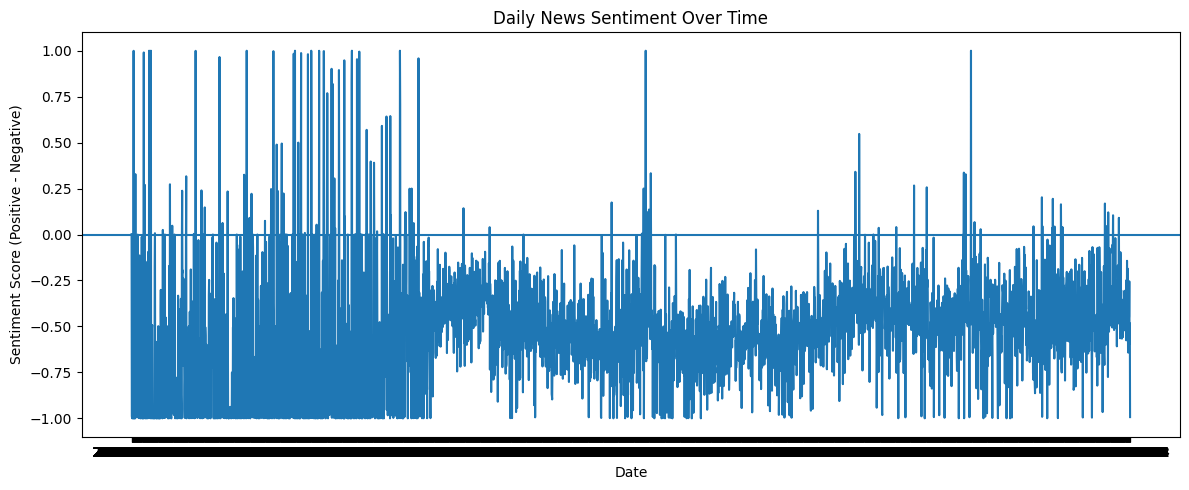

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(
    daily_sentiment["date"],
    daily_sentiment["sentiment_score"]
)

plt.axhline(0)
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Positive - Negative)")
plt.title("Daily News Sentiment Over Time")

plt.tight_layout()
plt.show()